# Lab Six: CNNs

Team: Mike Wisniewski

In [1]:
import glob
import numpy as np
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import io
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Input
from tensorflow.keras.utils import plot_model
from sklearn import metrics as mt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import ShuffleSplit
from PIL import Image, ImageOps

In [2]:
# get a list of all picture paths
tumor = list(glob.glob('lab6_dataset/tumor/*'))
normal = list(glob.glob('lab6_dataset/normal/*'))

In [3]:
# create a dictionary that holds labels and paths for each image type
df_images = {
    'tumor' : tumor,
    'normal' : normal
}

Text(0.5, 1.0, 'normal')

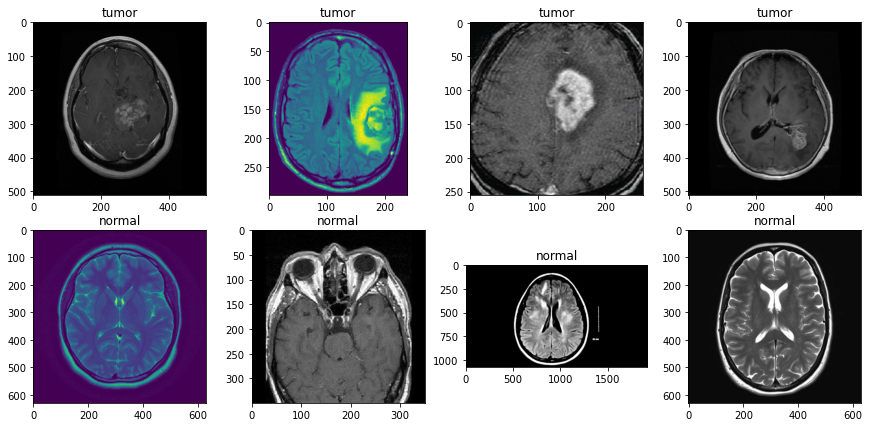

In [4]:
# plot out an image to see what it looks like
fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(10,10))
fig.set_size_inches(15, 7)

ax[0][0].imshow(img.imread(tumor[0]))
ax[0][1].imshow(img.imread(tumor[1]))
ax[0][2].imshow(img.imread(tumor[2]))
ax[0][3].imshow(img.imread(tumor[3]))
ax[1][0].imshow(img.imread(normal[0]))
ax[1][1].imshow(img.imread(normal[1]))
ax[1][2].imshow(img.imread(normal[2]))
ax[1][3].imshow(img.imread(normal[3]))
ax[0][0].set_title("tumor")
ax[0][1].set_title("tumor")
ax[0][2].set_title("tumor")
ax[0][3].set_title("tumor")
ax[1][0].set_title("normal")
ax[1][1].set_title("normal")
ax[1][2].set_title("normal")
ax[1][3].set_title("normal")

NOTE: The lowest image was 167, 175 therefore we reduce the image size down to 150, 150

In [ ]:
# preprocessing parameters
image_h = 150
image_w = 150
image_c = 3
image_size = (image_h, image_w, image_c)

In [6]:
# read in the datasets and labels
dataset, labels = [], []

for label, images in df_images.items():
    for image in images:
        
        # read in image as grayscale and resize image down to 150 x 150
        arr = Image.open(image).convert("RGB").resize((150, 150))

        # append to dataset array
        dataset.append(np.array(arr))

        # extract labels
        labels.append(label)
        
dataset = np.array(dataset)
labels = np.array(labels)

In [ ]:
# # read in the datasets and labels
# dataset, labels = [], []

# for label, images in df_images.items():
#     for image in images:
        
#         # we do a try because some images got corrupted and come back as 0x0 matrices
#         try:
#             # read in image as grayscale and resize image down to 150 x 150
#             arr = Image.open(image)
#             arr = np.asarray(ImageOps.grayscale(arr).resize((image_h, image_w)))
            
#             # append to dataset array
#             dataset.append(arr)
            
#             # extract labels
#             labels.append(label)
#         except AttributeError:
#             pass
        
# # convert dataset to numpy array
# dataset = np.array(dataset)

# # expand the dimensions to include the channel dimension (grayscale)
# dataset = np.expand_dims(dataset, 3)

Text(0.5, 1.0, 'normal')

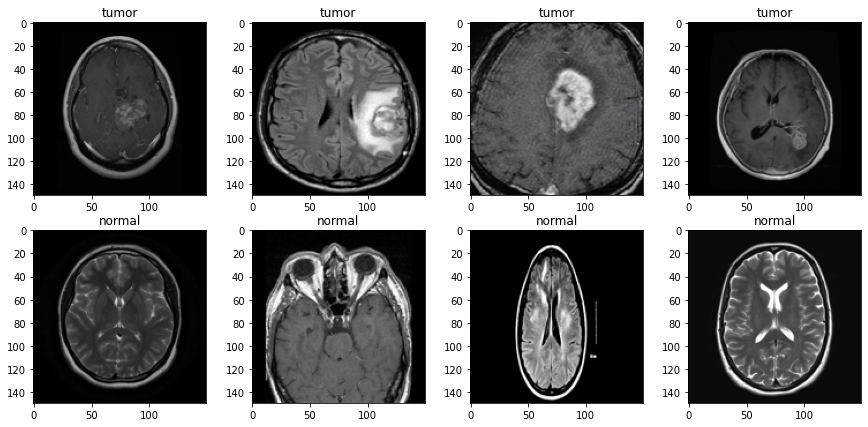

In [7]:
# plot out an image to see what it looks like
fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(10,10))
fig.set_size_inches(15, 7)

ax[0][0].imshow(dataset[0])
ax[0][1].imshow(dataset[1])
ax[0][2].imshow(dataset[2])
ax[0][3].imshow(dataset[3])
ax[1][0].imshow(dataset[2513])
ax[1][1].imshow(dataset[2514])
ax[1][2].imshow(dataset[2515])
ax[1][3].imshow(dataset[2516])
ax[0][0].set_title("tumor")
ax[0][1].set_title("tumor")
ax[0][2].set_title("tumor")
ax[0][3].set_title("tumor")
ax[1][0].set_title("normal")
ax[1][1].set_title("normal")
ax[1][2].set_title("normal")
ax[1][3].set_title("normal")

In [8]:
# describe the dataset
shape_of_dataset = dataset.shape
n_samples = dataset.shape[0]
n_features = dataset.shape[1]**2
classes = np.unique(labels)
n_classes = len(classes)

print("The shape of our dataset:", f'{shape_of_dataset}')
print("The number of samples in our dataset:", f'{n_samples}')
print("The number of features in our dataset:", f'{n_features}')
print("The number of classes in our dataset:", f'{n_classes}')
print("The classes are:", f'{classes}')

The shape of our dataset: (4600, 150, 150, 3)
The number of samples in our dataset: 4600
The number of features in our dataset: 22500
The number of classes in our dataset: 2
The classes are: ['normal' 'tumor']


> [1.5 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.



Our metrics of choice in order of importance for our model:

   - F1 Score
   - Precision
   - Accuracy
   - AUC
   - Binary Cross Entropy
   
Similar to lab 5, I have helper functions defined below to assist in extracting and plotting our important metrics.

In [9]:
# this is taken from lecture and repurposed for this exercise
def summarize_net(net, X_test, y_test, title_text=''):
    plt.figure(figsize=(15,5))
    yhat = net.predict(X_test)
    yhat[yhat<0.5] = 0 
    yhat[yhat>=0.5] = 1
    acc = mt.accuracy_score(y_test,yhat)
    cm = mt.confusion_matrix(y_test,yhat)
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=np.unique(labels),yticklabels=np.unique(labels))
    plt.title(title_text+'{:.4f}'.format(acc))

In [10]:
def plot_cf_matrix(model, X_test, y_test):
    # predict y using the test dataset
    yhat_proba = model.predict(X_test)
    yhat = np.round(yhat_proba)

    # assess the precision and f1_scores
    print(mt.confusion_matrix(y_test,yhat))
    print(mt.classification_report(y_test,yhat))

In [11]:
def plot_metrics(scores):
    # plot out loss plus metrics
    plt.figure(figsize=(15,15))
    
    plt.subplot(5,2,1)
    plt.title('Training')
    for score in scores:
        plt.plot(score["binary_crossentropy"])
    plt.ylabel('Binary Cross Entropy Loss')
    plt.legend([1,2,3,4,5])
    
    plt.subplot(5,2,3)
    for score in scores:
        plt.plot(score["recall"])
    plt.ylabel('Recall')
    
    plt.subplot(5,2,5)
    for score in scores:
        plt.plot(score["precision"])
    plt.ylabel('Precision')
    
    plt.subplot(5,2,7)
    for score in scores:
        plt.plot(score["auc"])
    plt.ylabel('AUC')
    
    plt.subplot(5,2,9)
    for score in scores:
        plt.plot(score["Accuracy"])
    plt.ylabel('Accuracy')
    
    plt.subplot(5,2,2)
    plt.title('Validation')
    for score in scores:
        plt.plot(score["val_binary_crossentropy"])
        
    plt.subplot(5,2,4)
    for score in scores:
        plt.plot(score["val_recall"])

    plt.subplot(5,2,6)
    for score in scores:
        plt.plot(score["val_precision"])

    plt.subplot(5,2,8)
    for score in scores:
        plt.plot(score["val_auc"])
        
    plt.subplot(5,2,10)
    for score in scores:
        plt.plot(score["val_Accuracy"])
        
    model_ = 1
    avg_val_f1 = []
    for score in scores:
        model_precision = sum(score["val_precision"])/len(score["val_precision"])
        model_recall = sum(score["val_recall"])/len(score["val_recall"])
        model_f1 = 2*model_precision*model_recall/(model_precision + model_recall)
        print(f"Model {model_} Validation F1:", model_f1)
        avg_val_f1.append(model_f1)
        model_ += 1
        
    print(f"Average Model Validation F1 Score:", sum(avg_val_f1)/len(avg_val_f1))

In [12]:
def mcnemar_test(acc1, acc2):
    t = 2.26 / np.sqrt(10)  # 2.26 is looked up in a book for 95% CI
    e1 = 1-acc1
    e2 = 1-acc1
    e = e1 - e2
    stdtot = np.std(e)
    dbar = np.mean([e1, e2])

    print(dbar - t * stdtot, dbar + t * stdtot)
    return dbar - t * stdtot, dbar + t * stdtot

In [13]:
def avg_metric(scores, metric="precision"):
    # get the average precision for both the first DNN and the best NN
    metric_table = []
    for score in scores:
        if metric_table:
            metric_table = list(np.add(score[metric], metric_table))
        else:
            metric_table += score[metric]    
    metric_table = np.divide(metric_table,5)
    
    return metric_table

> [1.5 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice.

In [14]:
# select cross validation
cv = ShuffleSplit(n_splits=5)

In [15]:
# shuffle the dataset as it was read in order of tumor and then normal
from sklearn.utils import shuffle
np.random.seed(42)
dataset, labels = shuffle(dataset, labels)

In [17]:
# initialize our X, y (data, labels) - used throughout this notebook
X = []
X_scaled = []
y = labels

"""
Following section we will perform the following operations:
    1. Intialize a scaler
    2. Iterate through each image
    3. Flatten each image
    4. Scale each image
    5. Reshape each image back into original shape (256, 256, 1)
"""

# 1. initialize scaler
scaler = StandardScaler()

# 2. iterate through each image
for image in dataset:
    
    # 3. flatten image
    img = image.ravel()
    
    # append to X
    X.append(img)
    
# 4. scale dataset
X = scaler.fit_transform(X)

for image in X:
    
    # 5. Reshape each image back to original shape
    img = image.reshape(image_h, image_w, 3)
    
    # append to X_scaled
    X_scaled.append(img)

# encode y labels
encoder = LabelEncoder()
y_ohe = encoder.fit_transform(y)

# extract X_scaled from inside list
X_scaled = np.asarray(X_scaled)

In [18]:
# split X and y into train, test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_ohe, test_size=0.2, random_state=42)

> [1.5 points]  Setup the training to use data expansion in Keras (also called data augmentation). Explain why the chosen data expansion techniques are appropriate for your dataset. You can use the keras ImageGenerator as a pre-processing step OR in the optimization loop. You can also use the Keras-cv augmenter (a separate package: https://keras.io/keras_cv/ Links to an external site.)

In [19]:
# initialize Image Data Generator
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=5, # used, Int. Degree range for random rotations.
    width_shift_range=0.1, # used, Float (fraction of total width). Range for random horizontal shifts.
    height_shift_range=0.1, # used,  Float (fraction of total height). Range for random vertical shifts.
    shear_range=0., # Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=None)

# fit the data on train
datagen.fit(X_train)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


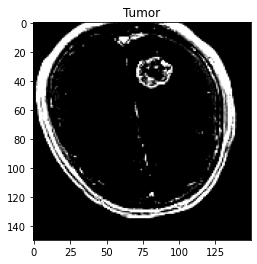

In [22]:
# print out an example of a generated image
tmps = datagen.flow(X_train, y_train, batch_size=1)

for tmp in tmps:
    plt.imshow(tmp[0].squeeze(),cmap='bone')
    if tmp[1][0] == 0:
        plt.title("Normal")
    else:
        plt.title("Tumor")
    break

> [2 points] Create a convolutional neural network to use on your data using Keras. Investigate at least two different convolutional network architectures (and investigate changing some parameters of each architecture such as the number of filters--at minimum have two variations of each network for a total of four models trained). Use the method of train/test splitting and evaluation metric that you argued for at the beginning of the lab. Visualize the performance of the training and validation sets per iteration (use the "history" parameter of Keras). Be sure that models converge. 

In [ ]:
# model parameters
optimizer = "adam"
loss = "binary_crossentropy"
metrics = ["Precision", "Recall", "Accuracy", "AUC", "binary_crossentropy"]
kernel_initializer = "glorot_uniform"
input_shape = image_size
conv_layer_activation = "relu"
dense_layer_activation = "tanh"
final_activation = "sigmoid"
epochs = 25
batch_size = 64

### Base Model (MLP)
Base model MLP with 3 Dense layers

In [27]:
def base_model(input_shape):
    
    # initialize a convolutional neural network
    mlp = Sequential()

    # flatten input image
    mlp.add(Flatten())
    
    # add first dense layer
    mlp.add(Dense(input_dim=input_dim, units=128, activation=dense_layer_activation, kernel_initializer=kernel_initializer))
    
    # add dropout
    mlp.add(Dropout(0.2))
    
    # add second dense layer
    mlp.add(Dense(128, activation=dense_layer_activation, kernel_initializer=kernel_initializer))
    
    # add dropout
    mlp.add(Dropout(0.2))
    
    # add third dense layer
    mlp.add(Dense(64, activation=dense_layer_activation, kernel_initializer=kernel_initializer))
    
    # add output layer
    mlp.add(Dense(1, activation=final_activation))

    # Let's train the model 
    mlp.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    
    return mlp

In [ ]:
# initialize empty list of scores
base_model_scores = []

cv_split = 1

# initialize model
input_dim = X_train.shape[1]**2
base_model = base_model(input_shape)

# iterate through each CV and observe the model
for train_index, test_index in cv.split(X_train, y_train):
    
    print(f"On Split {cv_split}")
    
    X_train_cv = X_train[train_index]
    y_train_cv = y_train[train_index]
    X_test_cv = X_train[test_index]
    y_test_cv = y_train[test_index]
    
    

    # fit the model
    base_model_history = base_model.fit(datagen.flow(X_train_cv, y_train_cv, batch_size=batch_size), 
                            steps_per_epoch=int(len(X_train_cv)/batch_size), epochs=epochs, verbose=0, 
                            validation_data=(X_test_cv,y_test_cv))
    
    # append scores
    base_model_scores.append(base_model_history.history)
    
    cv_split += 1

On Split 1


In [ ]:
# summarize model
base_model.summary()

In [ ]:
# plot model architecture
plot_model(
    base_model, show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [ ]:
# summarize the last model to run
summarize_net(base_model, X_test, y_test, title_text='Using Expansion:')

In [ ]:
# plot the confusion matrix of the last model to run
plot_cf_matrix(base_model, X_test, y_test)

In [ ]:
# plot metrics for first simple model
plot_metrics(base_model_scores)

### Simple Model 1
Model 1 is designed to be simple with as many same-value parameters.  

In [ ]:
# define first model
def model1():
    
    # initialize a convolutional neural network
    cnn = Sequential()

    # add first convolutional layer
    cnn.add(Conv2D(filters=32,
                    input_shape=input_shape,
                    kernel_size=(3,3), 
                    padding='same', 
                    activation=conv_layer_activation, kernel_initializer=kernel_initializer))

    # add second convolutional layer
    cnn.add(Conv2D(filters=32,
                    kernel_size=(3,3), 
                    padding='same', 
                    activation=conv_layer_activation, kernel_initializer=kernel_initializer))

    # add first max pooling
    cnn.add(MaxPooling2D(pool_size=(2, 2)))

    # flatten output
    cnn.add(Flatten())
    
    # add first dense layer
    cnn.add(Dense(32, activation=dense_layer_activation, kernel_initializer=kernel_initializer))
    
    # add output layer
    cnn.add(Dense(1, activation=final_activation))

    # Let's train the model 
    cnn.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    
    return cnn

In [ ]:
# initialize empty list of scores
simple_model1_scores = []

cv_split = 1

# initialize model
simple_model1 = model1()

# iterate through each CV and observe the model
for train_index, test_index in cv.split(X_train, y_train):
    
    print(f"On Split {cv_split}")
    
    X_train_cv = X_train[train_index]
    y_train_cv = y_train[train_index]
    X_test_cv = X_train[test_index]
    y_test_cv = y_train[test_index]

    # fit the model
    simple_model1_history = simple_model1.fit(datagen.flow(X_train_cv, y_train_cv, batch_size=batch_size), 
                            steps_per_epoch=int(len(X_train_cv)/batch_size), epochs=epochs, verbose=0, 
                            validation_data=(X_test_cv,y_test_cv))
    
    # append scores
    simple_model1_scores.append(simple_model1_history.history)
    
    cv_split += 1

In [ ]:
# summarize model
simple_model1.summary()

In [ ]:
# plot model architecture
plot_model(
    simple_model1, show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [ ]:
# summarize the last model to run
summarize_net(simple_model1, X_test, y_test, title_text='Using Expansion:')

In [ ]:
# plot the confusion matrix of the last model to run
plot_cf_matrix(simple_model1, X_test, y_test)

In [ ]:
# plot metrics for first simple model
plot_metrics(simple_model1_scores)

### Simple Model 2
Changes made:
    
    - Changed filters for both CNNs to 64
    - Changed padding to "valid"
    - Changed 2nd Conv2D Layer to have an activation of tanh
    - Changed number of neurons in first Dense layer to 128

In [ ]:
# define second model
def model2():
    
    # initialize a convolutional neural network
    cnn = Sequential()

    # add first convolutional layer
    cnn.add(Conv2D(filters=64,
                    input_shape=input_shape,
                    kernel_size=(3,3), 
                    padding='valid', 
                    activation=conv_layer_activation, kernel_initializer=kernel_initializer))

    # add second convolutional layer
    cnn.add(Conv2D(filters=64,
                    kernel_size=(3,3), 
                    padding='valid', 
                    activation="tanh", kernel_initializer=kernel_initializer))

    # add first max pooling
    cnn.add(MaxPooling2D(pool_size=(2, 2)))

    # flatten output
    cnn.add(Flatten())
    
    # add first dense layer
    cnn.add(Dense(128, activation=dense_layer_activation, kernel_initializer=kernel_initializer))
    
    # add output layer
    cnn.add(Dense(1, activation=final_activation))

    # Let's train the model 
    cnn.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    
    return cnn

In [ ]:
# initialize empty list of scores
simple_model2_scores = []

cv_split = 1

# initialize model
simple_model2 = model2()

# iterate through each CV and observe the model
for train_index, test_index in cv.split(X_train, y_train):
    
    print(f"On Split {cv_split}")
    
    X_train_cv = X_train[train_index]
    y_train_cv = y_train[train_index]
    X_test_cv = X_train[test_index]
    y_test_cv = y_train[test_index]


    
    # fit the model
    simple_model2_history = simple_model2.fit(datagen.flow(X_train_cv, y_train_cv, batch_size=batch_size), 
                            steps_per_epoch=int(len(X_train_cv)/batch_size), epochs=epochs, verbose=0, 
                            validation_data=(X_test_cv,y_test_cv))
    
    # append scores
    simple_model2_scores.append(simple_model2_history.history)
    
    cv_split += 1

In [ ]:
# summarize model
simple_model2.summary()

In [ ]:
# plot model architecture
plot_model(
    simple_model2, show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [ ]:
# summarize the last model to run
summarize_net(simple_model2, X_test, y_test, title_text='Using Expansion:')

In [ ]:
# plot the confusion matrix of the last model to run
plot_cf_matrix(simple_model2, X_test, y_test)

In [ ]:
# plot metrics for first simple model
plot_metrics(simple_model2_scores)

### Complex Model 1
Model 1 is designed to be simple with as many same-value parameters.  Additions include:

    - Added a 3rd Conv2D layer
    - Added a 4th Conv2D layers
    - Added a 2nd MaxPooling2D layer after the 4th Conv2D layer
    - Added Dropout of 20% before flattening
    - Added Dropout of 20% after the first Dense layer
    - Added a 2nd Dense layer
    - Added Dropout of 10% after the 2nd Dense layer
    - Added a 3rd Dense layer
    - Added Dropout of 5% after the 3rd Dense layer

In [ ]:
# define second model
def model3():
    
    # initialize a convolutional neural network
    cnn = Sequential()

    # add first convolutional layer
    cnn.add(Conv2D(filters=64,
                    input_shape=input_shape,
                    kernel_size=(3,3), 
                    padding='same', 
                    activation=conv_layer_activation, kernel_initializer=kernel_initializer))

    # add second convolutional layer
    cnn.add(Conv2D(filters=64,
                    kernel_size=(3,3), 
                    padding='same', 
                    activation=conv_layer_activation, kernel_initializer=kernel_initializer))

    # add first max pooling
    cnn.add(MaxPooling2D(pool_size=(2, 2)))
    
    # add third convolutional layer
    cnn.add(Conv2D(filters=32,
                    kernel_size=(3,3), 
                    padding='same', 
                    activation=conv_layer_activation, kernel_initializer=kernel_initializer))

    # add second convolutional layer
    cnn.add(Conv2D(filters=32,
                    kernel_size=(3,3), 
                    padding='same', 
                    activation=conv_layer_activation, kernel_initializer=kernel_initializer))

    # add first max pooling
    cnn.add(MaxPooling2D(pool_size=(2, 2)))
    
    # add dropout
    cnn.add(Dropout(0.2))

    # flatten output
    cnn.add(Flatten())
    
    # add first dense layer
    cnn.add(Dense(128, activation=dense_layer_activation, kernel_initializer=kernel_initializer))
    
    # add dropout
    cnn.add(Dropout(0.2))
    
    # add second dense layer
    cnn.add(Dense(64, activation=dense_layer_activation, kernel_initializer=kernel_initializer))
    
    # add dropout
    cnn.add(Dropout(0.1))
    
    # add third dense layer
    cnn.add(Dense(32, activation=dense_layer_activation, kernel_initializer=kernel_initializer))
    
    # add dropout
    cnn.add(Dropout(0.05))
    
    # add output layer
    cnn.add(Dense(1, activation=final_activation))

    # Let's train the model 
    cnn.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    
    return cnn

In [ ]:
# initialize empty list of scores
complex_model1_scores = []

cv_split = 1

# initialize model
complex_model1 = model3()

# iterate through each CV and observe the model
for train_index, test_index in cv.split(X_train, y_train):
    
    print(f"On Split {cv_split}")
    
    X_train_cv = X_train[train_index]
    y_train_cv = y_train[train_index]
    X_test_cv = X_train[test_index]
    y_test_cv = y_train[test_index]
   
    # fit the model
    complex_model1_history = complex_model1.fit(datagen.flow(X_train_cv, y_train_cv, batch_size=batch_size), 
                            steps_per_epoch=int(len(X_train_cv)/batch_size), epochs=epochs, verbose=0, 
                            validation_data=(X_test_cv,y_test_cv))
    
    # append scores
    complex_model1_scores.append(complex_model1_history.history)
    
    cv_split += 1

In [ ]:
# summarize model
complex_model1.summary()

In [ ]:
# plot model architecture
plot_model(
    complex_model1, show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [ ]:
# summarize the last model to run
summarize_net(complex_model1, X_test, y_test, title_text='Using Expansion:')

In [ ]:
# plot the confusion matrix of the last model to run
plot_cf_matrix(complex_model1, X_test, y_test)

In [ ]:
# plot metrics for first simple model
plot_metrics(complex_model1_scores)

### Complex Model 2
Model 1 is designed to be simple with as many same-value parameters.  Changes include:

    - Reducing the 1st Conv2D layer filters from 64 to 32
    - Reducing the 2nd Conv2D layer filters from 64 to 32
    - Switching the 2nd Conv2D layer activation function from relu to tanh
    - Reducing the 3rd Conv2D layer filters from 32 to 16
    - Reducing the 4th Conv2D layer filters from 32 to 16
    - Switching the 4th Conv2D layer activation function from relu to tanh
    - Increasing the 1st Dropout from 20% to 50%
    - Increasing the 2nd Dropout from 20% to 25%
    - Increasing the 3rd Dropout from 10% to 20%
    - Increasing the 4th Dropout from 5% to 20%
    - Setting all dense layers to 32 neurons (128, 64, and 32 were the respective priors)
    
My idea behind this model is to decrease the total number of trainable parameters to make the model "simpler".  I believe in the majority of use cases, simpler is better.  This was the aim of this fourth model.  In the context of a tumor, I believe this is intuitive.  A tumor has only so many features about it.  Most tumors are round in shape.  The model is trying to identify an "out of place" round object.  In my opinion, this model does not need millions of parameters to identify odd looking edges, therefore I justify my reason to decrease my model trainable parameters with this logic.

In [ ]:
# define second model
def model4():
    
    # initialize a convolutional neural network
    cnn = Sequential()

    # add first convolutional layer
    cnn.add(Conv2D(filters=32,
                    input_shape=input_shape,
                    kernel_size=(3,3), 
                    padding='same', 
                    activation=conv_layer_activation, kernel_initializer=kernel_initializer))

    # add second convolutional layer
    cnn.add(Conv2D(filters=32,
                    kernel_size=(3,3), 
                    padding='same', 
                    activation="tanh", kernel_initializer=kernel_initializer))

    # add first max pooling
    cnn.add(MaxPooling2D(pool_size=(2, 2)))
    
    # add third convolutional layer
    cnn.add(Conv2D(filters=16,
                    kernel_size=(3,3), 
                    padding='same', 
                    activation=conv_layer_activation, kernel_initializer=kernel_initializer))

    # add second convolutional layer
    cnn.add(Conv2D(filters=16,
                    kernel_size=(3,3), 
                    padding='same', 
                    activation="tanh", kernel_initializer=kernel_initializer))

    # add first max pooling
    cnn.add(MaxPooling2D(pool_size=(2, 2)))
    
    # add dropout
    cnn.add(Dropout(0.5))

    # flatten output
    cnn.add(Flatten())
    
    # add first dense layer
    cnn.add(Dense(32, activation=dense_layer_activation, kernel_initializer=kernel_initializer))
    
    # add dropout
    cnn.add(Dropout(0.25))
    
    # add second dense layer
    cnn.add(Dense(32, activation=dense_layer_activation, kernel_initializer=kernel_initializer))
    
    # add dropout
    cnn.add(Dropout(0.2))
    
    # add third dense layer
    cnn.add(Dense(32, activation=dense_layer_activation, kernel_initializer=kernel_initializer))
    
    # add dropout
    cnn.add(Dropout(0.2))
    
    # add output layer
    cnn.add(Dense(1, activation=final_activation))

    # Let's train the model 
    cnn.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    
    return cnn

In [ ]:
# initialize empty list of scores
complex_model2_scores = []

cv_split = 1

# initialize model
complex_model2 = model4()

# iterate through each CV and observe the model
for train_index, test_index in cv.split(X_train, y_train):
    
    print(f"On Split {cv_split}")
    
    X_train_cv = X_train[train_index]
    y_train_cv = y_train[train_index]
    X_test_cv = X_train[test_index]
    y_test_cv = y_train[test_index]
   
    # fit the model
    complex_model2_history = complex_model2.fit(datagen.flow(X_train_cv, y_train_cv, batch_size=batch_size), 
                            steps_per_epoch=int(len(X_train_cv)/batch_size), epochs=epochs, verbose=0, 
                            validation_data=(X_test_cv,y_test_cv))
    
    # append scores
    complex_model2_scores.append(complex_model2_history.history)
    
    cv_split += 1

In [ ]:
# summarize model
complex_model2.summary()

In [ ]:
# plot model architecture
plot_model(
    complex_model2, show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [ ]:
# summarize the last model to run
summarize_net(complex_model2, X_test, y_test, title_text='Using Expansion:')

In [ ]:
# plot the confusion matrix of the last model to run
plot_cf_matrix(complex_model2, X_test, y_test)

In [ ]:
# plot metrics for first simple model
plot_metrics(complex_model2_scores)

> [1.5 points] Visualize the final results of the CNNs and interpret/compare the performances. Use proper statistics as appropriate, especially for comparing models. 

In [ ]:
def f1_score_calc(precision, recall):
    return 2 * np.multiply(precision, recall)/np.add(precision, recall)

In [ ]:
# get the F1 Scores for each model
simple_model1_f1 = f1_score_calc(precision=simple_model1_scores[4]["val_precision"], recall=simple_model1_scores[4]["val_recall"])
simple_model2_f1 = f1_score_calc(precision=simple_model2_scores[4]["val_precision"], recall=simple_model2_scores[4]["val_recall"])
complex_model1_f1 = f1_score_calc(precision=complex_model1_scores[4]["val_precision"], recall=complex_model1_scores[4]["val_recall"])
complex_model2_f1 = f1_score_calc(precision=complex_model2_scores[4]["val_precision"], recall=complex_model2_scores[4]["val_recall"])

In [ ]:
# plot out all model F1 scores
plt.title('F1 Score Comparisons')
plt.plot(simple_model1_f1)
plt.plot(simple_model2_f1)
plt.plot(complex_model1_f1)
plt.plot(complex_model2_f1)
plt.ylabel('F1 Score')
plt.xlabel('Number of Epochs')
plt.legend(["Simple Model 1", "Simple Model 2", "Complex Model 1", "Complex Model 2"])

In [ ]:
# get the average AUC for all models
simple_model1_auc = avg_metric(scores=simple_model1_scores, metric="val_auc")
simple_model2_auc = avg_metric(scores=simple_model2_scores, metric="val_auc")
complex_model1_auc = avg_metric(scores=complex_model1_scores, metric="val_auc")
complex_model2_auc = avg_metric(scores=complex_model2_scores, metric="val_auc")

In [ ]:
# plot out all model AUC
plt.title('AUC Comparisons')
plt.plot(simple_model1_auc)
plt.plot(simple_model2_auc)
plt.plot(complex_model1_auc)
plt.plot(complex_model2_auc)
plt.ylabel('AUC')
plt.xlabel('Number of Epochs')
plt.legend(["Simple Model 1", "Simple Model 2", "Complex Model 1", "Complex Model 2"])

In [ ]:
# mcnemar test between models
simple_model1_accuracy = avg_metric(scores=simple_model1_scores, metric="val_Accuracy")
simple_model2_accuracy = avg_metric(scores=simple_model2_scores, metric="val_Accuracy")
complex_model1_accuracy = avg_metric(scores=complex_model1_scores, metric="val_Accuracy")
complex_model2_accuracy = avg_metric(scores=complex_model2_scores, metric="val_Accuracy")

mcnemar_test(simple_model1_accuracy, simple_model2_accuracy)
mcnemar_test(simple_model1_accuracy, complex_model1_accuracy)
mcnemar_test(simple_model1_accuracy, complex_model2_accuracy)
mcnemar_test(simple_model2_accuracy, complex_model1_accuracy)
mcnemar_test(simple_model2_accuracy, complex_model2_accuracy)
mcnemar_test(complex_model1_accuracy, complex_model2_accuracy)

> [1 points] Compare the performance of your convolutional network to a standard multi-layer perceptron (MLP) using the receiver operating characteristic and area under the curve. Use proper statistical comparison techniques. 

In [ ]:
base_model_f1 = f1_score_calc(precision=base_model_scores[4]["val_precision"], recall=base_model_scores[4]["val_recall"])
base_model_auc = avg_metric(scores=base_model_scores, metric="val_auc")
base_model_accuracy = avg_metric(scores=base_model_scores, metric="val_Accuracy")

In [ ]:
# plot out all model F1 scores
plt.title('F1 Score Comparisons')
plt.plot(complex_model1_f1)
plt.plot(complex_model2_f1)
plt.ylabel('F1 Score')
plt.xlabel('Number of Epochs')
plt.legend(["Complex Model 1", "Base Model"])

In [ ]:
# plot out all model AUC
plt.title('AUC Comparisons')
plt.plot(complex_model1_auc)
plt.plot(base_model_auc)
plt.ylabel('AUC')
plt.xlabel('Number of Epochs')
plt.legend(["Complex Model 1", "Base Model"])

In [ ]:
mcnemar_test(complex_model1_accuracy, base_model_accuracy)

> One idea (required for 7000 level students): Use transfer learning to pre-train the weights of your initial layers of your CNN. Compare the performance when using transfer learning to training without transfer learning (i.e., compare to your best model from above) in terms of classification performance. 

In [ ]:
# read in the datasets and labels
d_dataset, l_labels = [], []

for label, images in df_images.items():
    for image in images:
        
        # read in image as grayscale and resize image down to 150 x 150
        arr = Image.open(image).convert("RGB").resize((64, 64))

        # append to dataset array
        d_dataset.append(np.array(arr))

        # extract labels
        l_labels.append(label)
        
d_dataset = np.array(d_dataset)
l_labels = np.array(l_labels)

In [ ]:
# shuffle the dataset as it was read in order of tumor and then normal
from sklearn.utils import shuffle
np.random.seed(42)
d_dataset, l_labels = shuffle(d_dataset, l_labels)

In [ ]:
x_train = d_dataset[:3680]
y_train = l_labels[:3680]
x_test = d_dataset[3680:]
y_test = l_labels[3680:]

enc = LabelEncoder()
y_train_ohe = enc.fit_transform(y_train)
y_test_ohe = enc.fit_transform(y_test)

In [ ]:
x_train_up = x_train
x_test_up = x_test

x_train_up = np.stack(x_train_up, axis=0)
x_test_up = np.stack(x_test_up, axis=0)
print(x_train_up.shape)
print(x_test_up.shape)

In [ ]:
x_train_up = [Image.fromarray(x).resize(size=(150,150)) for x in x_train]
x_train_up = np.stack(x_train_up, axis=0)
print(x_train_up.shape)

x_test_up = [Image.fromarray(x).resize(size=(150,150)) for x in x_test]
x_test_up = np.stack(x_test_up, axis=0)
print(x_test_up.shape)

In [ ]:
# connect new layers to the output
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
# from tensorflow.keras.applications.resnet50 import ResNet50
# from tensorflow.keras.applications.resnet50 import preprocess_input

res_no_top = Xception(weights='imagenet', include_top=False)

x_train_up = preprocess_input(x_train_up)
x_test_up = preprocess_input(x_test_up)

In [ ]:
%%time

# train on half the data, to save a few hours
x_train_resnet = res_no_top.predict(x_train_up)
x_test_resnet = res_no_top.predict(x_test_up)
print(x_train_resnet.shape)

In [ ]:
input_x = Input(shape=x_train_resnet[0].shape)

# add first max pooling
pool1 = MaxPooling2D(pool_size=(2, 2))(input_x)

# add dropout
drop1 = Dropout(0.2)(pool1)

# flatten output
flat = Flatten()(drop1)

# add first dense layer
dense1 = Dense(128, activation=dense_layer_activation, kernel_initializer=kernel_initializer)(flat)

# add dropout
drop2 = Dropout(0.2)(dense1)

# add second dense layer
dense2 = Dense(64, activation=dense_layer_activation, kernel_initializer=kernel_initializer)(drop2)

# add dropout
drop3 = Dropout(0.1)(dense2)

# add third dense layer
dense3 = Dense(32, activation=dense_layer_activation, kernel_initializer=kernel_initializer)(drop3)

# add dropout
drop4 = Dropout(0.05)(dense3)

# add output layer
predictions = Dense(1, activation=final_activation)(drop4)

model = Model(inputs=input_x, outputs=predictions)
model.summary()

In [ ]:
# initialize empty list of scores
transfer_model_scores = []

cv_split = 1

# initialize model
# complex_model2 = model4()
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# iterate through each CV and observe the model
for train_index, test_index in cv.split(x_train, y_train):
    
    print(f"On Split {cv_split}")
    
    x_train_cv = x_train_resnet[train_index]
    y_train_cv = y_train_ohe[train_index]
    x_test_cv = x_train_resnet[test_index]
    y_test_cv = y_train_ohe[test_index]
   
    # fit the model
    transfer_model_history = model.fit(x_train_cv,y_train_cv,epochs=epochs, batch_size=batch_size, verbose=False, validation_data=(x_test_cv, y_test_cv))
    
    # append scores
    transfer_model_scores.append(transfer_model_history.history)
    
    cv_split += 1

In [ ]:
# plot model architecture
plot_model(
    model, show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [ ]:
# summarize the last model to run
summarize_net(model, x_test_resnet, y_test_ohe, title_text='Using Expansion:')

In [ ]:
# plot the confusion matrix of the last model to run
plot_cf_matrix(model, x_test_resnet, y_test_ohe)

In [ ]:
plot_metrics(transfer_model_scores)